# CIFAR-10

In [1]:
#Setting the path to the dataset
CIFAR_10 = '../DataSet/cifar-10-batches-py/'

In [2]:
#Unpickling the data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
#Setting names of the files
dirs = ['batches.meta','data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4','data_batch_5', 'test_batch']

In [4]:
#Array storing the information
all_data = [0,1,2,3,4,5,6]

In [5]:
#Going to the array to store it
for i,direc in zip(all_data, dirs):
    all_data[i] = unpickle(CIFAR_10+direc)

In [6]:
#Setting each element to a varaible name
batch_meta = all_data[0]
data_batch_1 = all_data[1]
data_batch_2 = all_data[2]
data_batch_3 = all_data[3]
data_batch_4 = all_data[4]
data_batch_5 = all_data[5]
test_batch = all_data[6]

batch_meta

In [7]:
#Printing the keys
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
#Importing matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#Setting x to the data
X = data_batch_1[b"data"]

In [10]:
#Reshaping the flatten data back to 32 by 32
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [11]:
#Printing the shape
X[0].shape

(32, 32, 3)

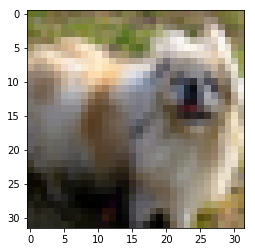

In [12]:
#Showing the image on matplotlib
plt.imshow(X[40])

In [13]:
#Running through the reshaping step by step
X = data_batch_1[b"data"]

In [14]:
X.shape

(10000, 3072)

In [15]:
all_image = X.reshape(10000, 3, 32, 32)

In [16]:
sample = all_image[0]

In [17]:
sample.transpose(1,2,0).shape

(32, 32, 3)

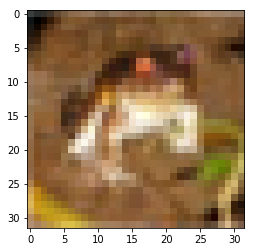

In [18]:
plt.imshow(sample.transpose(1,2,0))

In [19]:
#Helper function to one hot encode the results
def one_hot_encode(vec,vals=10):
    n = len(vec)
    out = np.zeros([n,vals])
    out[range(n), vec] = 1
    return out

In [20]:
#Helper functions to prep the data
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch_1,data_batch_2,data_batch_3,data_batch_4,data_batch_5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [21]:
#Preping the data
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [22]:
#importing tensorflow
import tensorflow as tf

In [23]:
#Creating placeholder for x and y_true
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [24]:
#Dropout placeholder
hold_prob =  tf.placeholder(tf.float32)

In [25]:
#Helper function to create the convolutional neural networl=k
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pooling_2by2(x):
    return tf.nn.max_pool(x,strides=[1,2,2,1], ksize=[1,2,2,1], padding='SAME')

def convolutional_layer(input_x,shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,W)+b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W)+b

In [26]:
#Creating a convolutional neural network and max pooling it
convo_1 = convolutional_layer(x, shape=[4, 4, 3, 32])
convo_1_pooling = max_pooling_2by2(convo_1)

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
#Same as before but with a new layer and different shape
convo_2 = convolutional_layer(convo_1_pooling, shape=[4, 4, 32, 64])
convo_2_pooling = max_pooling_2by2(convo_2)

In [28]:
#Flatten convo_2_pooling
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [29]:
#Create a fully connect layer
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [30]:
#Create a dropuout layet
full_one_dropout = tf.nn.dropout(full_layer_one,rate=1-hold_prob)

In [31]:
#Get the prediction at the final layer
y_pred = normal_full_layer(full_one_dropout,10)

In [32]:
#Cross entropy for error
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [33]:
#Optimizer and taininer to minimize cross_entropy
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [34]:
#Initialize Global variablies
init = tf.global_variables_initializer()

In [35]:
#Run session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(10000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
           
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1


Currently on step 100
Accuracy is:
0.3931


Currently on step 200
Accuracy is:
0.462


Currently on step 300
Accuracy is:
0.5104


Currently on step 400
Accuracy is:
0.5238


Currently on step 500
Accuracy is:
0.5424


Currently on step 600
Accuracy is:
0.5769


Currently on step 700
Accuracy is:
0.5935


Currently on step 800
Accuracy is:
0.5775


Currently on step 900
Accuracy is:
0.5914


Currently on step 1000
Accuracy is:
0.6209


Currently on step 1100
Accuracy is:
0.6253


Currently on step 1200
Accuracy is:
0.6352


Currently on step 1300
Accuracy is:
0.6228


Currently on step 1400
Accuracy is:
0.6391


Currently on step 1500
Accuracy is:
0.6493


Currently on step 1600
Accuracy is:
0.6551


Currently on step 1700
Accuracy is:
0.6668


Currently on step 1800
Accuracy is:
0.6434


Currently on step 1900
Accuracy is:
0.6496


Currently on step 2000
Accuracy is:
0.6626


Currently on step 2100
Accuracy is:
0.6786


Currently on step 2200
Acc